<a href="https://colab.research.google.com/github/rociotarda/TP1---Datos/blob/main/analisis_exploratorio_martin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
id='1Su8VBZNHOqwzBIA_-hiMtUdhS6-p6Kte'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_values.csv')

In [5]:
id_2='1ct-Uk6jmJWZ4-g-ryvCINzDSmLsRYBlN'
downloaded = drive.CreateFile({'id': id_2})
downloaded.GetContentFile('train_labels.csv')

In [6]:
train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')

#Análisis previo sobre el DataFrame train_values.



In [ ]:
train_values.head(5)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Nos fijamos información relevante sobre los datos del DataFrame 
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [ ]:
#Nos fijamos si faltan datos en las columnas
train_values.isnull().value_counts()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  age    area_percentage  height_percentage  land_surface_condition  foundation_type  roof_type  ground_floor_type  other_floor_type  position  plan_configuration  has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  has_superstructure_stone_flag  has_superstructure_cement_mortar_stone  has_superstructure_mud_mortar_brick  has_superstructure_cement_mortar_brick  has_superstructure_timber  has_superstructure_bamboo  has_superstructure_rc_non_engineered  has_superstructure_rc_engineered  has_superstructure_other  legal_ownership_status  count_families  has_secondary_use  has_secondary_use_agriculture  has_secondary_use_hotel  has_secondary_use_rental  has_secondary_use_institution  has_secondary_use_school  has_secondary_use_industry  has_secondary_use_health_post  has_secondary_use_gov_office  has_secondary_use_use_police  has_secondary_use_other
False        False           False           Fal

Con la información obtenida arriba, podemos verificar que no faltan datos.

In [ ]:
#Nos fijamos si hay registros duplicados
train_values.duplicated(keep=False).value_counts()

False    260601
dtype: int64

In [ ]:
#Nos fijamos si hay registros duplicados sin tener en cuenta el id del edificio
train_values.iloc[:, 1:].duplicated(keep=False).value_counts()

False    232057
True      28544
dtype: int64

Esto último nos dice que casi el 11% de los edificios comparten las mismas caraterísticas. Al tener un id diferente, consideramos que no hay que eliminar esos datos porque es muy probable que la misma empresa constructora o grupo de personas que construía edificios, templos, casas, etc (dependiendo el contexto socio-cultural en la línea de tiempo de la historia de la humanidad) los haya construído.

# Familias afectadas

In [ ]:
train_values['count_families'].value_counts()

1    226115
0     20862
2     11294
3      1802
4       389
5       104
6        22
7         7
9         4
8         2
Name: count_families, dtype: int64

In [7]:
train_values_reduced = train_values[['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_families']]
train_values_reduced_with_damage = train_values_reduced.merge(train_labels, left_on='building_id', right_on='building_id')
train_values_reduced_with_damage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   building_id     260601 non-null  int64
 1   geo_level_1_id  260601 non-null  int64
 2   geo_level_2_id  260601 non-null  int64
 3   geo_level_3_id  260601 non-null  int64
 4   count_families  260601 non-null  int64
 5   damage_grade    260601 non-null  int64
dtypes: int64(6)
memory usage: 13.9 MB


Notamos que hay 20862 edificios en los cuales no vivían familias, entonces para el siguiente análisis no tiene mucho sentido que los contemplemos. Veremos qué daños recibieron los edificios donde viviían las familias:

In [8]:
train_values_reduced_with_damage_for_affected_families = train_values_reduced_with_damage.loc[train_values_reduced_with_damage['count_families'] != 0, :]

In [9]:
affected_buildings = train_values_reduced_with_damage_for_affected_families.groupby(['count_families', 'damage_grade']).agg({'damage_grade':'count'})
affected_buildings.columns = ['damage_grade_count']
affected_buildings.reset_index(inplace=True)
affected_buildings.columns = ['Count families', 'Damage grade', 'Damage grade count']
affected_buildings.head()

,Count families,Damage grade,Damage grade count
0,1,1,20339
1,1,2,129721
2,1,3,76055
3,2,1,829
4,2,2,6021


In [10]:
affected_buildings_pivot = affected_buildings.pivot(index='Count families', columns='Damage grade', values='Damage grade count')
affected_buildings_pivot = affected_buildings_pivot.fillna(0)
affected_buildings_pivot

Damage grade,1,2,3
Count families,,,
1,"20,339.00","129,721.00","76,055.00"
2,829.00,"6,021.00","4,444.00"
3,221.00,886.00,695.00
4,46.00,205.00,138.00
5,17.00,51.00,36.00
6,4.00,8.00,10.00
7,3.00,2.00,2.00
8,1.00,1.00,0.00
9,1.00,3.00,0.00


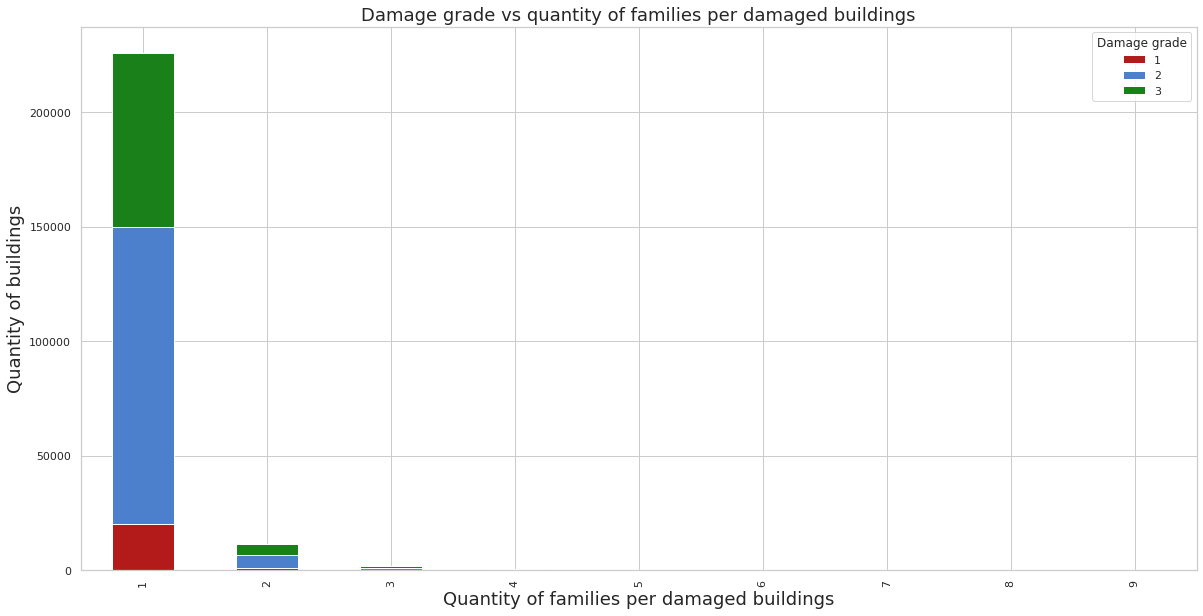

In [11]:
plot = affected_buildings_pivot.plot.bar(color=[(0.7, 0.1, 0.1), (0.3, 0.5, 0.8), (0.1, 0.5, 0.1)], stacked=True, figsize=(20,10))
plot.set_title("Damage grade vs quantity of families per damaged buildings", fontsize=18)
plot.set_ylabel("Quantity of buildings", fontsize=18);
plot.set_xlabel("Quantity of families per damaged buildings", fontsize=18);

A partir de este gráfico, observamos que la mayor cantidad de familias afectadas se encunetran en los edificios en donde vivía solamente una familia, seguido de los edificios donde vivían dos familias y el resto de ellas. En ambos casos, la mayoría del daño de los edificos fue nivel dos y luego nivel tres, por lo que, la mayor cantidad de las familias de las zonas afectadas por el terremoto, tuvieron que refaccionar sus hogares y/o abandonarlos.

La distribución de los datos analizados en el gráfico anterior, nos lleva a analizar cómo se distribuye el daño por distrito de los edificios en donde viven una y más familias de las tres zonas geográficas, por lo que analizaremos estos casos por separado. Primero, analizaremos para una sola familia ya que los edificios donde vivía una familia fueron los más afectados. Luego, analizaremos para más de una familia ya que no hay mucha información en el gráfico de arriba sobre el daño que recibieron y cómo afecta a las familias.

 A continuación, veremos los daños que recibieron los edificios donde vivía una sola familia en los distritos de las tres regiones:

In [12]:
affected_buildings_where_lives_1_family = train_values_reduced_with_damage_for_affected_families.loc[train_values_reduced_with_damage_for_affected_families['count_families'] == 1, :]



*   Región 1



In [15]:
affected_buildings_where_lives_1_family_region_1 = affected_buildings_where_lives_1_family.groupby(['geo_level_1_id', 'damage_grade']).agg({'damage_grade':'count'})
affected_buildings_where_lives_1_family_region_1.columns = ['damage_grade_count']
affected_buildings_where_lives_1_family_region_1.reset_index(inplace=True)
affected_buildings_where_lives_1_family_region_1.columns = ['Region 1', 'Damage grade', 'Damage grade count']
affected_buildings_where_lives_1_family_region_1.head()

,Region 1,Damage grade,Damage grade count
0,0,1,320
1,0,2,3000
2,0,3,589
3,1,1,390
4,1,2,1921


In [16]:
affected_buildings_where_lives_1_family_region_1_pivot = affected_buildings_where_lives_1_family_region_1.pivot(index='Region 1', columns='Damage grade', values='Damage grade count')
affected_buildings_where_lives_1_family_region_1_pivot = affected_buildings_where_lives_1_family_region_1_pivot.fillna(0)
affected_buildings_where_lives_1_family_region_1_pivot.head()

Damage grade,1,2,3
Region 1,,,
0,320.00,"3,000.00",589.00
1,390.00,"1,921.00",302.00
2,78.00,570.00,230.00
3,125.00,"4,079.00","2,544.00"
4,412.00,"9,474.00","2,450.00"


In [17]:
#Normalizamos las columnas
total = affected_buildings_where_lives_1_family_region_1_pivot[1] + affected_buildings_where_lives_1_family_region_1_pivot[2] + affected_buildings_where_lives_1_family_region_1_pivot[3]
affected_buildings_where_lives_1_family_region_1_pivot[1] = affected_buildings_where_lives_1_family_region_1_pivot[1]/total
affected_buildings_where_lives_1_family_region_1_pivot[2] = affected_buildings_where_lives_1_family_region_1_pivot[2]/total
affected_buildings_where_lives_1_family_region_1_pivot[3] = affected_buildings_where_lives_1_family_region_1_pivot[3]/total
affected_buildings_where_lives_1_family_region_1_pivot.head()

Damage grade,1,2,3
Region 1,,,
0,0.08,0.77,0.15
1,0.15,0.74,0.12
2,0.09,0.65,0.26
3,0.02,0.60,0.38
4,0.03,0.77,0.20


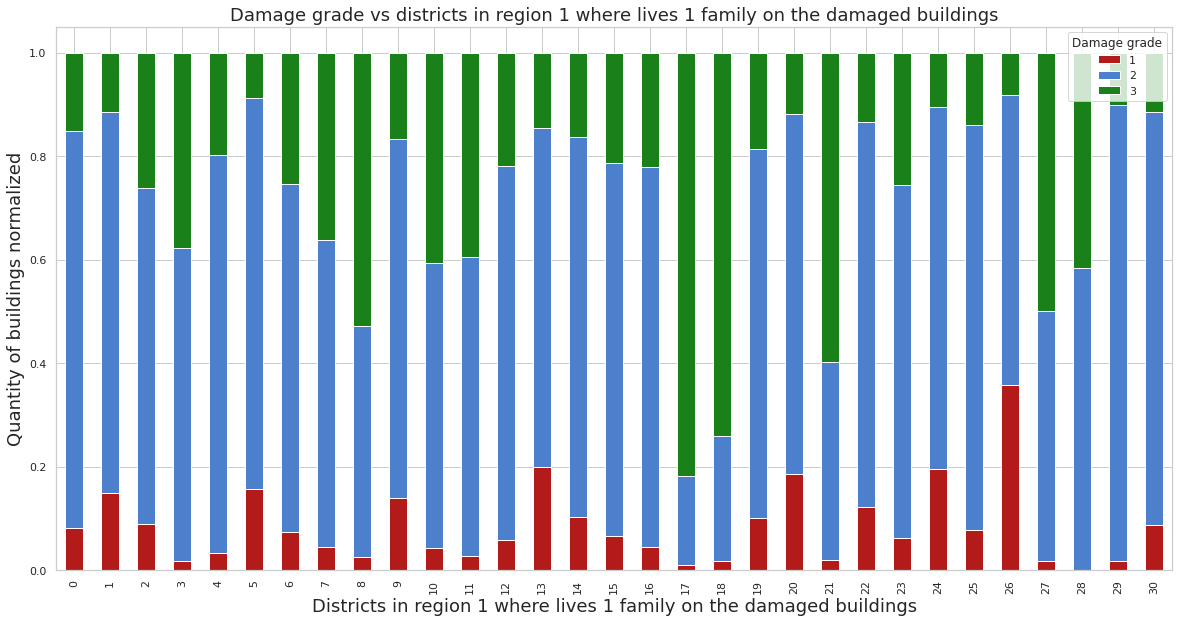

In [18]:
plot = affected_buildings_where_lives_1_family_region_1_pivot.plot.bar(color=[(0.7, 0.1, 0.1), (0.3, 0.5, 0.8), (0.1, 0.5, 0.1)],stacked=True, figsize=(20,10))
plot.set_title("Damage grade vs districts in region 1 where lives 1 family on the damaged buildings", fontsize=18)
plot.set_ylabel("Quantity of buildings normalized", fontsize=18);
plot.set_xlabel("Districts in region 1 where lives 1 family on the damaged buildings", fontsize=18);

Tuvimos que normalizar los datos para poder visualizar más concretamente los edificios (nos abstraemos de qué zona de la región uno es la más poblada) que fueron dañados en los distritos de la región uno y que vivía una familia. De esta forma, es fácil comparar qué tan dañados resultaron los edificios de la región uno por sus distritos.
Como conclusión, decimos que se observa claramente que los distritos 8, 17, 18 y 21 son los que fueron más afectados debido a que contaron con más del 50% de sus edificios muy o totalmente dañados. También vemos que el distrito 27 sigue esta tendencia porque, aproximadamente, el 50% de sus edificios está muy o totalmente dañado, el 48% esta con un daño mediano y el 2% está poco dañado y, en el balance, hay mayoría de edificios muy o totalmente dañados. A partir de esto, la mayoría de las familias que vivían en esos distritos perdieron sus hogares.
Todos los distritos contaron con pocos edificios con daño bajo ya que los edificios de todos los distritos restantes no llegan a representar ni el 40% de los edificios del distrito y tampoco representan la mayoría en el balance.
Finalmente, en el caso de todos los distritos, menos los mencionados en el segundo párrafo, tuvieron daño mediano debido a que contaron con más del 50% de sus edificios con este daño. Esto implica que las familias que vivían en estos distritos tuvieron que reparar sus hogares o bien, abandonarlos. Esto último depende de la situación económica de cada familia.



*   Región 2




In [68]:
affected_buildings_where_lives_1_family_region_2 = affected_buildings_where_lives_1_family.groupby('geo_level_2_id').agg({'damage_grade':'mean'})
affected_buildings_where_lives_1_family_region_2.columns = ['damage_grade_mean']
affected_buildings_where_lives_1_family_region_2.reset_index(inplace=True)
affected_buildings_where_lives_1_family_region_2.columns = ['Region 2', 'Damage grade mean']
affected_buildings_where_lives_1_family_region_2.head()

,Region 2,Damage grade mean
0,0,3.00
1,1,2.37
2,3,2.10
3,4,2.54
4,5,2.16


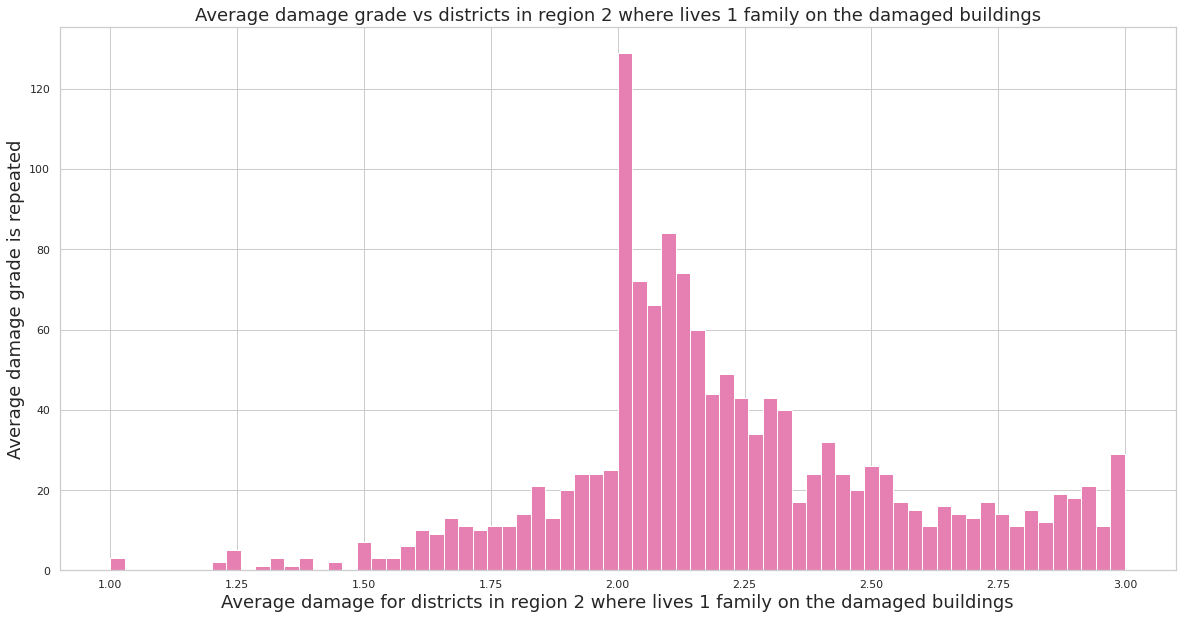

In [69]:
plot = affected_buildings_where_lives_1_family_region_2['Damage grade mean'].plot.hist(color=(0.9, 0.5, 0.7), bins=70, figsize=(20,10))
plot.set_title("Average damage grade vs districts in region 2 where lives 1 family on the damaged buildings", fontsize=18)
plot.set_ylabel("Average damage grade is repeated", fontsize=18);
plot.set_xlabel("Average damage for districts in region 2 where lives 1 family on the damaged buildings", fontsize=18);

Dado que son muchos distritos en la región 2, decidimos hacer un promedio del daño para cada distrito así podemos sacar una conclsusión fácilmente.

A partir del gráfico de arriba, podemos concluir que el daño promedio de los edificios donde vivía una familia de la región dos está en el intervalo (2, 2.10), aproximadamente. Esto nos indica que en la mayoría de los distritos de la región dos, los edificios donde vivía una familia fueron dañandos con daño mediano, lo que implica que las familias tuvieron que refaccionar sus hogares o abandonarlos, dependiendo de qué tan buena o mala sea la situación económica de cada familia.



*   Región 3



In [94]:
affected_buildings_where_lives_1_family_region_3 = affected_buildings_where_lives_1_family.groupby('geo_level_3_id').agg({'damage_grade':'mean'})
affected_buildings_where_lives_1_family_region_3.columns = ['damage_grade_mean']
affected_buildings_where_lives_1_family_region_3.reset_index(inplace=True)
affected_buildings_where_lives_1_family_region_3.columns = ['Region 3', 'Damage grade mean']
affected_buildings_where_lives_1_family_region_3.head()

,Region 3,Damage grade mean
0,0,3.00
1,1,2.50
2,3,1.88
3,5,1.15
4,6,2.68


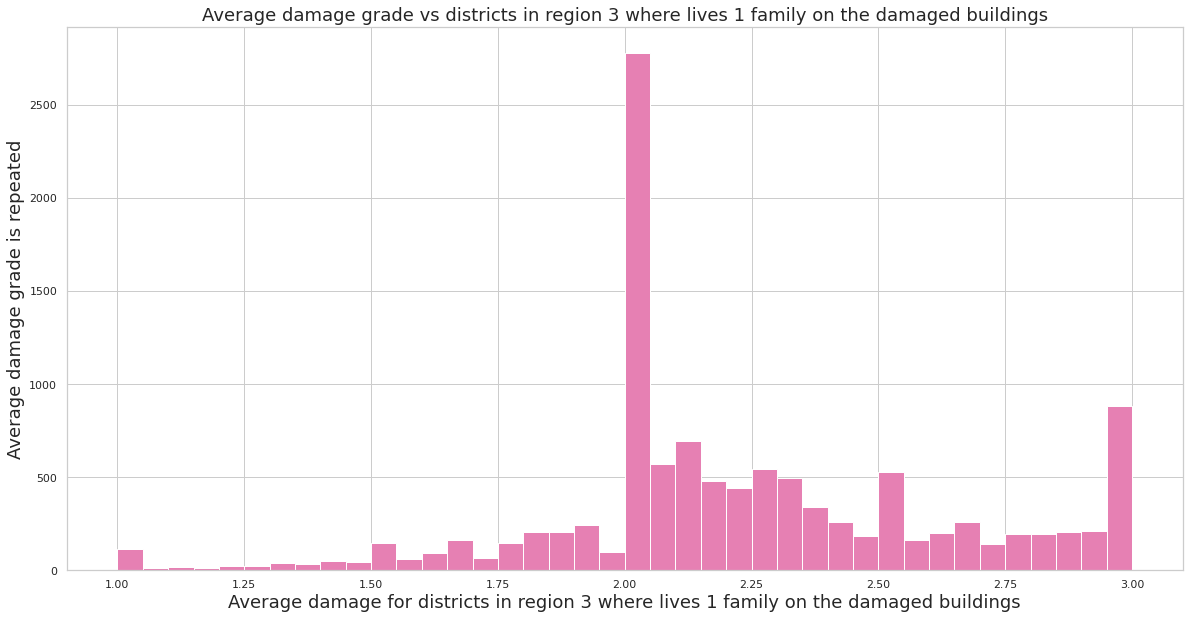

In [95]:
plot = affected_buildings_where_lives_1_family_region_3['Damage grade mean'].plot.hist(color=(0.9, 0.5, 0.7), bins=40, figsize=(20,10))
plot.set_title("Average damage grade vs districts in region 3 where lives 1 family on the damaged buildings", fontsize=18)
plot.set_ylabel("Average damage grade is repeated", fontsize=18);
plot.set_xlabel("Average damage for districts in region 3 where lives 1 family on the damaged buildings", fontsize=18);

Hicimos lo mismo que en la región dos dado que son muchos distritos. A partir del gráfico de arriba, podemos concluir que el daño promedio de los edificios donde vivía una familia de la región tres está en el intervalo (2, 2.05), aproximadamente. Esto nos indica que en la mayoría de los distritos de la región tres, los edificios donde vivía una familia fueron dañandos con daño mediano, lo que implica que las familias tuvieron que refaccionar sus hogares o abandonarlos, dependiendo de qué tan buena o mala sea la situación económica de cada familia.

--------------------------------------------------------------------------------

 A continuación, veremos los daños que recibieron los edificios donde vivía más de una sola familia en los distritos de las tres regiones:

In [37]:
affected_buildings_where_lives_more_than_1_family = train_values_reduced_with_damage_for_affected_families.loc[train_values_reduced_with_damage_for_affected_families['count_families'] > 1, :]

* Región 1

In [40]:
affected_buildings_where_lives_more_than_1_family_region_1 = affected_buildings_where_lives_more_than_1_family.groupby(['geo_level_1_id', 'damage_grade']).agg({'damage_grade':'count'})
affected_buildings_where_lives_more_than_1_family_region_1.columns = ['damage_grade_count']
affected_buildings_where_lives_more_than_1_family_region_1.reset_index(inplace=True)
affected_buildings_where_lives_more_than_1_family_region_1.columns = ['Region 1', 'Damage grade', 'Damage grade count']
affected_buildings_where_lives_more_than_1_family_region_1.head()

,Region 1,Damage grade,Damage grade count
0,0,2,16
1,0,3,4
2,1,1,11
3,1,2,30
4,1,3,2


In [42]:
affected_buildings_where_lives_more_than_1_family_region_1_pivot = affected_buildings_where_lives_more_than_1_family_region_1.pivot(index='Region 1', columns='Damage grade', values='Damage grade count')
affected_buildings_where_lives_more_than_1_family_region_1_pivot = affected_buildings_where_lives_more_than_1_family_region_1_pivot.fillna(0)
affected_buildings_where_lives_more_than_1_family_region_1_pivot.head()

Damage grade,1,2,3
Region 1,,,
0,0.00,16.00,4.00
1,11.00,30.00,2.00
2,0.00,3.00,5.00
3,0.00,317.00,151.00
4,27.00,511.00,94.00


In [43]:
#Normalizamos las columnas
total = affected_buildings_where_lives_more_than_1_family_region_1_pivot[1] + affected_buildings_where_lives_more_than_1_family_region_1_pivot[2] + affected_buildings_where_lives_more_than_1_family_region_1_pivot[3]
affected_buildings_where_lives_more_than_1_family_region_1_pivot[1] = affected_buildings_where_lives_more_than_1_family_region_1_pivot[1]/total
affected_buildings_where_lives_more_than_1_family_region_1_pivot[2] = affected_buildings_where_lives_more_than_1_family_region_1_pivot[2]/total
affected_buildings_where_lives_more_than_1_family_region_1_pivot[3] = affected_buildings_where_lives_more_than_1_family_region_1_pivot[3]/total
affected_buildings_where_lives_more_than_1_family_region_1_pivot.head()

Damage grade,1,2,3
Region 1,,,
0,0.00,0.80,0.20
1,0.26,0.70,0.05
2,0.00,0.38,0.62
3,0.00,0.68,0.32
4,0.04,0.81,0.15


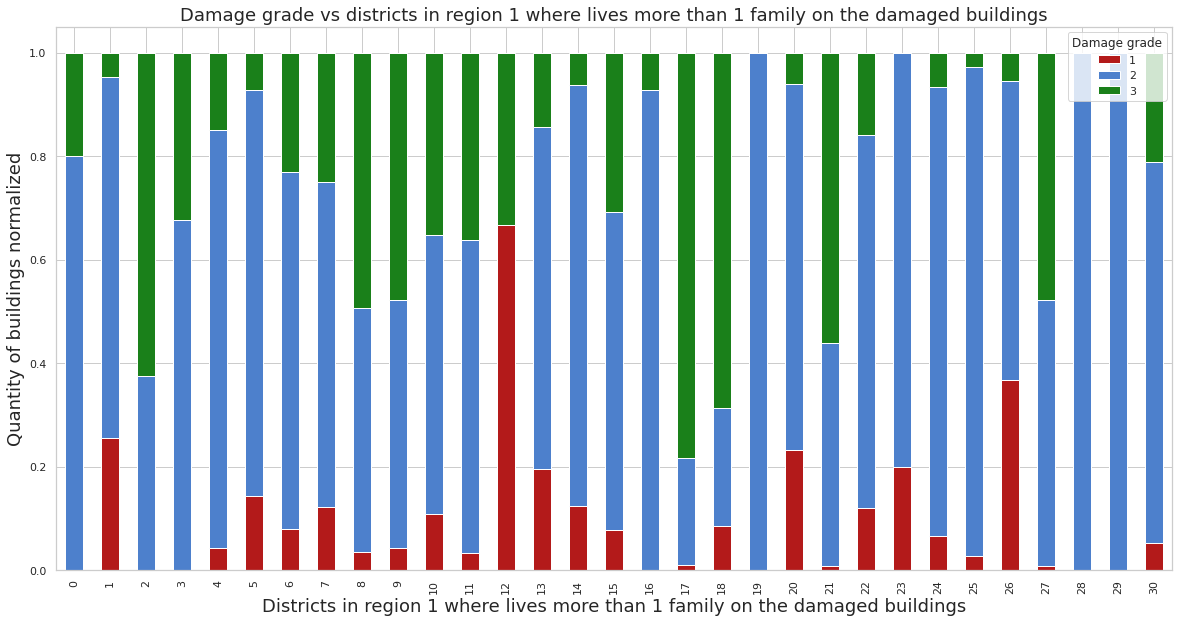

In [45]:
plot = affected_buildings_where_lives_more_than_1_family_region_1_pivot.plot.bar(color=[(0.7, 0.1, 0.1), (0.3, 0.5, 0.8), (0.1, 0.5, 0.1)],stacked=True, figsize=(20,10))
plot.set_title("Damage grade vs districts in region 1 where lives more than 1 family on the damaged buildings", fontsize=18)
plot.set_ylabel("Quantity of buildings normalized", fontsize=18);
plot.set_xlabel("Districts in region 1 where lives more than 1 family on the damaged buildings", fontsize=18);

Normalizamos los datos con el mismo fin que para el análisis hecho para los edificios de los distritos de la región uno y que vivía una familia, pero en este análisis vivían más de una familia en los edificios de los distritos de la región 1.

Como conclusión, decimos que se observa claramente que los distritos 2, 17, 18 y 21 son los que fueron más afectados debido a que contaron con más del 50% de sus edificios muy o totalmente dañados. También vemos que el distrito 8 sigue esta tendencia porque, aproximadamente, el 50% de sus edificios está muy o totalmente dañado, el 47% esta con un daño mediano y el 3% está poco dañado y, en el balance, hay mayoría de edificios muy o totalmente dañados. A partir de esto, la mayoría de las familias que vivían en esos distritos perdieron sus hogares. 

Todos los distritos contaron con un porcentaje de pocos edificios con daño bajo, a excepción del 12 que tuvo un 65% de edificios con daño bajo y esto implica que las familias que vivían allí no tuvieron grandes inconvenientes con sus hogares, ya que los edificios de todos los distritos restantes no llegan a representar ni el 40% de los edificios del distrito y tampoco representan la mayoría en el balance.

El distrito 27 está equilibrado en cuanto a la intensidad de daño de sus edificios ya que tiene 50% de sus edificioscon daño medio y el 50% de sus edificios muy o totalmente dañado. Igualmente, las familias que vivían en este distrito se vieron obligadas a refaccionar sus hogares (en el caso de que su hogar esté dentro de los edificios que recibieron un daño mediano y puedan pagarlo) o abandonarlos.

Finalmente, en el caso de todos los distritos, menos los mencionados en los párrafos anteriores, tuvieron daño mediano debido a que contaron con más del 50% de sus edificios con este daño. También vemos que el distrito 9 sigue esta tendencia ya que, aproximadamente, el 48% de sus edificios está con daño mediano, el 5% con daño bajo y 47% con mucho daño o totalmente dañado, pero al tener mayoría de edificios, en el balance, con daño mediano, entraría en esta catégoría. Esto implica que las familias que vivían en estos distritos tuvieron que reparar sus hogares o bien, abandonarlos. Esto último depende de la situación económica de cada familia.

**Comparación con el gráfico de la sección edificios dañados en la región uno donde vivía una familia:**

Comparándolo con el análisis que realizamos para los edificios dañados en la región uno donde vivía una familia, vemos que coinden casi todos los distritos más afectados (los que contienen un porcentaje mayor de edificios muy o totalmente dañados, respecto de los que resultaron dañados con daño bajo o mediano). Estos son el 8, 17, 18 y 21. Notamos, comprando los gráficos, que el gráfico realizado en el análisis de los edificios dañados en la región uno donde vivía una familia, en esos distritos, hay un porcentaje levemente mayor de los edificios dañados seriamente, respecto de los dañados con daño mediano y bajo que en el gráfico del análisis hecho en esta sección. 

También vemos que en el distrito 2 de esta sección, no hay edificios dañados con daño bajo, mientras que en el del análisis que realizamos para los edificios dañados en la región uno donde vivía una familia sí  hay y hay más predominio del porcentaje de edificios dañados con daño mediano; y que en el distrito 27 de esta sección, tampoco hay edificios dañados con daño bajo, mientras que en el del análisis que realizamos para los edificios dañados en la región uno donde vivía una familia sí hay y por no haber edificios dañados con daño bajo en el gráfico de esta sección se igualan los porcentajes de los edificios dañados con daño mediano y muy alto.

* Región 2

In [46]:
affected_buildings_where_lives_more_than_1_family_region_2 = affected_buildings_where_lives_more_than_1_family.groupby('geo_level_2_id').agg({'damage_grade':'mean'})
affected_buildings_where_lives_more_than_1_family_region_2.columns = ['damage_grade_mean']
affected_buildings_where_lives_more_than_1_family_region_2.reset_index(inplace=True)
affected_buildings_where_lives_more_than_1_family_region_2.columns = ['Region 2', 'Damage grade mean']
affected_buildings_where_lives_more_than_1_family_region_2.head()

,Region 2,Damage grade mean
0,0,3.00
1,1,2.50
2,4,2.35
3,7,2.37
4,8,2.20


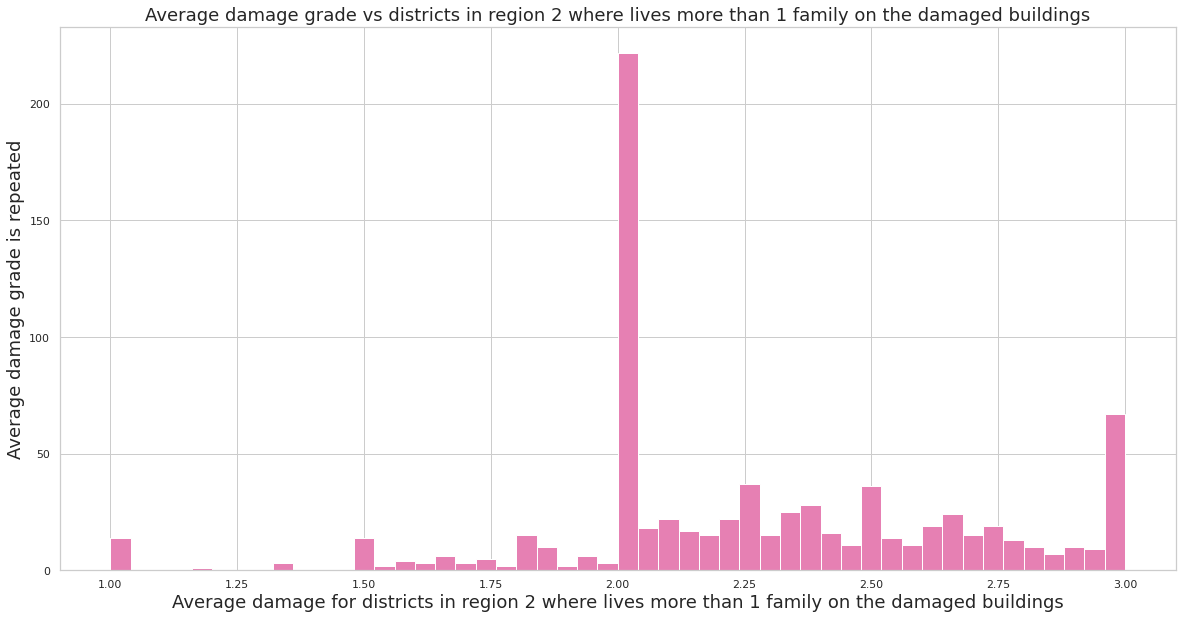

In [56]:
plot = affected_buildings_where_lives_more_than_1_family_region_2['Damage grade mean'].plot.hist(color=(0.9, 0.5, 0.7), bins=50, figsize=(20,10))
plot.set_title("Average damage grade vs districts in region 2 where lives more than 1 family on the damaged buildings", fontsize=18)
plot.set_ylabel("Average damage grade is repeated", fontsize=18);
plot.set_xlabel("Average damage for districts in region 2 where lives more than 1 family on the damaged buildings", fontsize=18);

Dado que son muchos distritos en la región 2, decidimos hacer un promedio del daño para cada distrito así podemos sacar una conclsusión fácilmente.

A partir del gráfico de arriba, podemos concluir que el daño promedio de los edificios donde vivía más de una familia de la región dos está en el intervalo (2, 2.05), aproximadamente. Esto nos indica que en la mayoría de los distritos de la región dos, los edificios donde vivía más de una familia fueron dañandos con daño mediano, lo que implica que las familias tuvieron que refaccionar sus hogares o abandonarlos, dependiendo de qué tan buena o mala sea la situación económica de cada familia.

**Comparación con el gráfico de la sección edificios dañados en la región dos donde vivía una familia:**

Comparándolo con el análisis que realizamos para los edificios dañados en la región dos donde vivía una familia, podemos observar que en el gráfico de esta sección están mucho más dispersos los daños promedios, pero se siguen acumulando en el mismo lugar (aproximadamente) ya que el daño promedio más grande sigue siendo cercano a dos. Esto quiere decir que para ambas secciones, por más que haya muchos más edificios en la seccion de los edificios dañados en la región dos donde vivía una familia que en esta, donde estamos realizando esta comparación, la tendencia se repite. Sin embargo, los daños promedio cercanos a tres y a uno se acumulan más que en la seccion de los edificios dañados en la región dos donde vivía una familia (en el párrafo siguiente, vamos a concluir al respecto).

Otra observación interesante es que, en esta sección, el daño promedio cercano a uno, dos y tres se repiten más veces que en la sección de los edificios dañados en la región dos donde vivía una familia (y eso que en la presente sección hay menos edificios). Eso es porque en la presente sección, la repetición de los daños promedios no entre uno, dos y tres se dan con menor frecuencia que en la otra sección, por lo que se acumulan menos y se dispersan más, facilitando que se acumulen más en los valores cercanos auno, a dos y a tres.

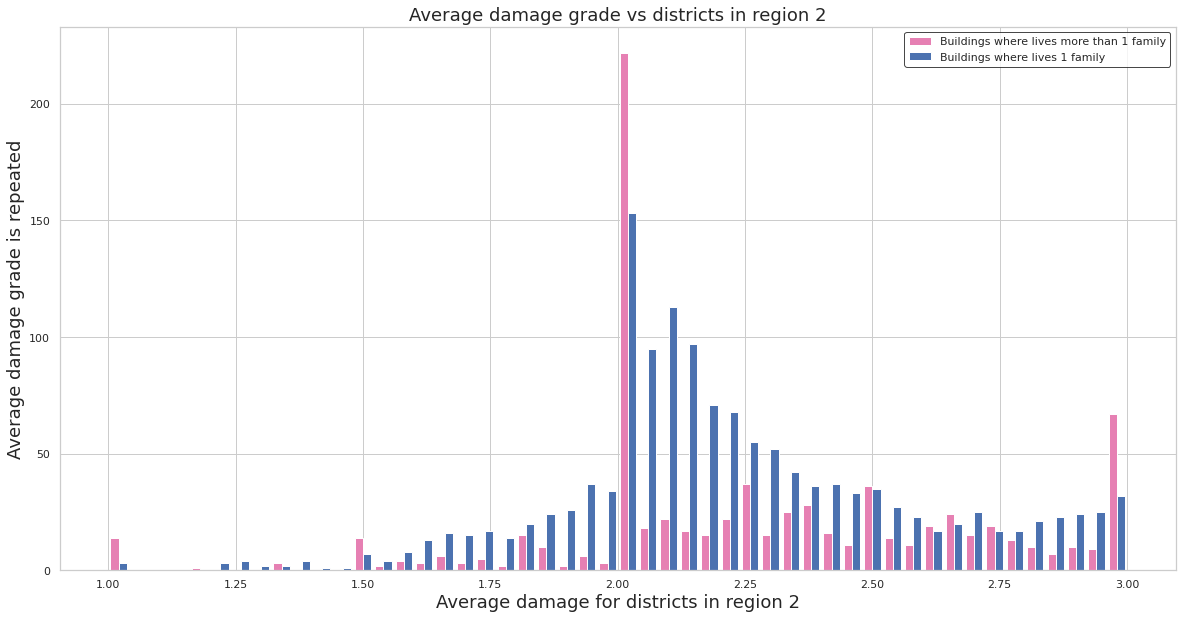

In [93]:
x=affected_buildings_where_lives_more_than_1_family_region_2['Damage grade mean']
y=affected_buildings_where_lives_1_family_region_2['Damage grade mean']

fig, ax = plt.subplots(figsize=(20,10))
ax.hist([x, y], bins=50, alpha=1, label=['Buildings where lives more than 1 family','Buildings where lives 1 family'], color=[(0.9, 0.5, 0.7), 'b'])

plt.title("Average damage grade vs districts in region 2", fontsize=18)
plt.legend(loc='upper right', edgecolor='k')
plt.xlabel("Average damage for districts in region 2", fontsize=18)
plt.ylabel("Average damage grade is repeated", fontsize=18)
plt.show()

* Región 3

In [57]:
affected_buildings_where_lives_more_than_1_family_region_3 = affected_buildings_where_lives_more_than_1_family.groupby('geo_level_3_id').agg({'damage_grade':'mean'})
affected_buildings_where_lives_more_than_1_family_region_3.columns = ['damage_grade_mean']
affected_buildings_where_lives_more_than_1_family_region_3.reset_index(inplace=True)
affected_buildings_where_lives_more_than_1_family_region_3.columns = ['Region 3', 'Damage grade mean']
affected_buildings_where_lives_more_than_1_family_region_3.head()

,Region 3,Damage grade mean
0,5,1.00
1,8,3.00
2,11,2.60
3,14,2.00
4,16,2.00


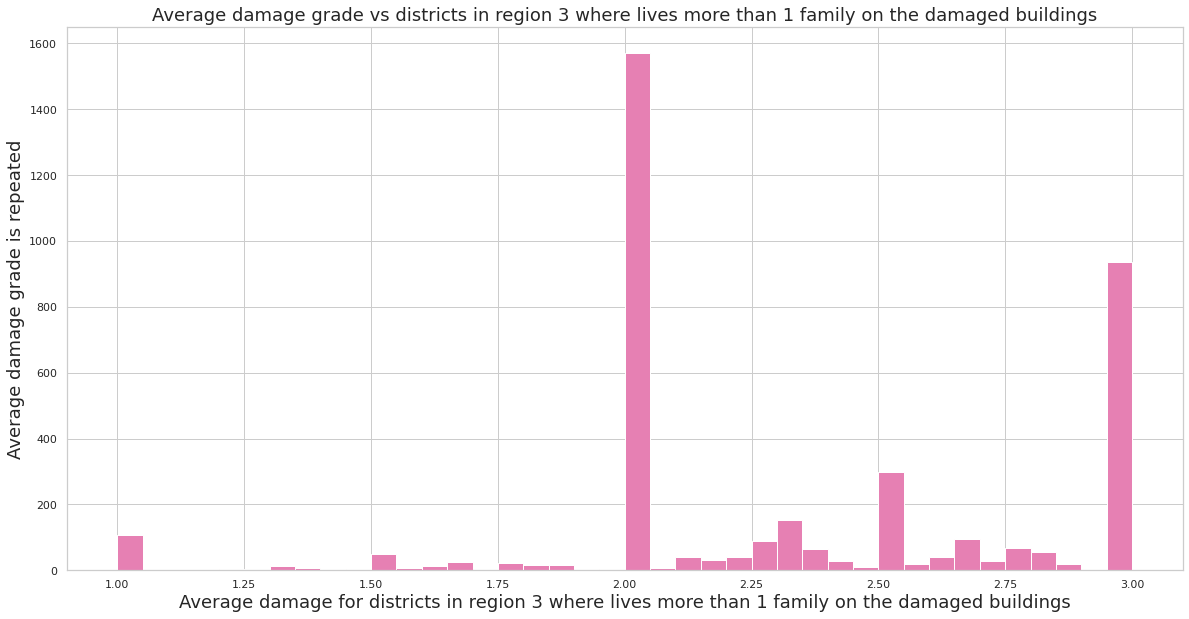

In [62]:
plot = affected_buildings_where_lives_more_than_1_family_region_3['Damage grade mean'].plot.hist(color=(0.9, 0.5, 0.7), bins=40, figsize=(20,10))
plot.set_title("Average damage grade vs districts in region 3 where lives more than 1 family on the damaged buildings", fontsize=18)
plot.set_ylabel("Average damage grade is repeated", fontsize=18);
plot.set_xlabel("Average damage for districts in region 3 where lives more than 1 family on the damaged buildings", fontsize=18);

Hicimos lo mismo que en la región tres dado que son muchos distritos. 

A partir del gráfico de arriba, podemos concluir que el daño promedio de los edificios donde vivía más de una familia de la región tres está muy cercano a dos. Esto nos indica que en la mayoría de los distritos de la región tres, los edificios donde vivía más de una familia fueron dañandos con daño mediano, lo que implica que las familias tuvieron que refaccionar sus hogares o abandonarlos, dependiendo de qué tan buena o mala sea la situación económica de cada familia.

**Comparación con el gráfico de la sección edificios dañados en la región tres donde vivía una familia:**

Comparándolo con el análisis que realizamos para los edificios dañados en la región tres donde vivía una familia, podemos observar que en el gráfico de esta sección se acumulan de la misma manera, aproximadamente, pero con menor cantidad (lógico porque son menos edificios). Sin embargo, para los daños promedios cercanos a tres, se acumuló aproximadamente la misma cantidad de repeticiones que para los edificios dañados en la región tres donde vivía una familia (dato curioso, ya que hay menos edificios en esta sección). Esto implica que, en proporción, hubieron más edificios que recibieron un daño promedio muy cercano a tres. 

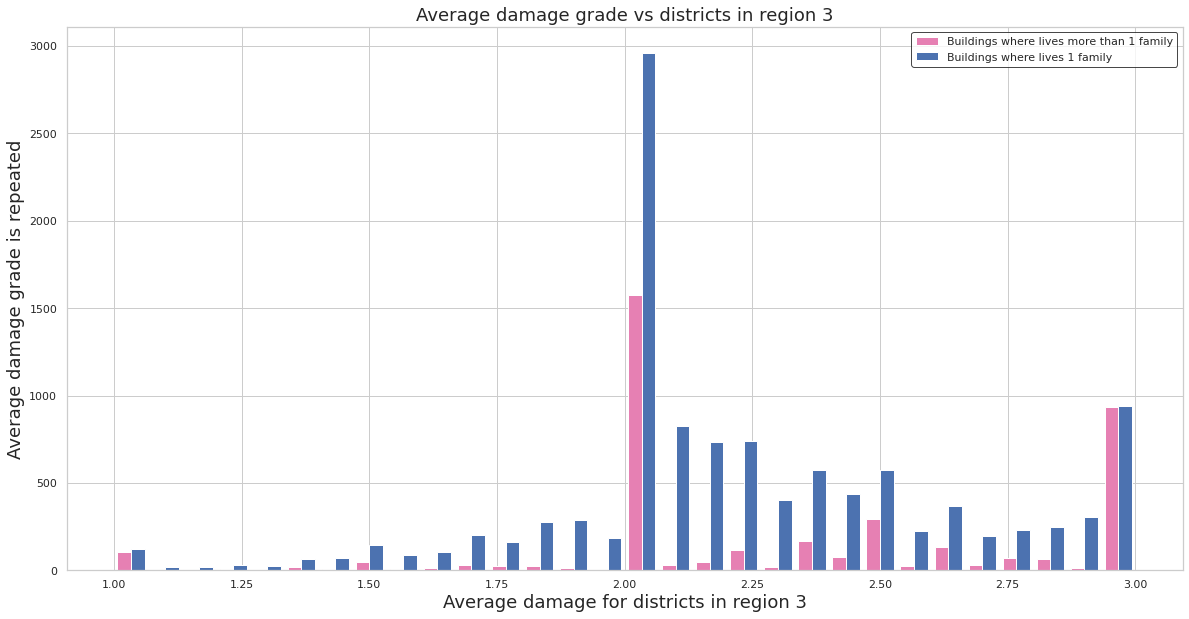

In [98]:
x=affected_buildings_where_lives_more_than_1_family_region_3['Damage grade mean']
y=affected_buildings_where_lives_1_family_region_3['Damage grade mean']

fig, ax = plt.subplots(figsize=(20,10))
ax.hist([x, y], bins=30, alpha=1, label=['Buildings where lives more than 1 family','Buildings where lives 1 family'], color=[(0.9, 0.5, 0.7), 'b'])

plt.title("Average damage grade vs districts in region 3", fontsize=18)
plt.legend(loc='upper right', edgecolor='k')
plt.xlabel("Average damage for districts in region 3", fontsize=18)
plt.ylabel("Average damage grade is repeated", fontsize=18)
plt.show()

**Conclusión general de en qué regiones las familias se vieron más afectadas**

Como conclusión a todo este análisis, podemos agrupar lo visto para la región uno, por un lado, lo visto para la región dos, por otro, y lo visto para la región tres, por otro.

Para la región uno, concluimos que las familias que vivían en la región 8, 17, 18 y 21 fueron las más afectadas por lo descrito en sección correspondiente a este análisis. Tomamos la intersección de las regiones para una familia y más de una familia que vivía en los edificios.

Para la región dos, concluimos que, a partir de los gráficos exhibidos anteriormente, los distritos de esta región tuvieron un daño mediano por lo que las familias tuvieron que reparar sus hogares y en caso de no poder, abandonarlos. 

Para la región tres, concluimos que, a partir de los gráficos exhibidos anteriormente, los distritos de esta región tuvieron un daño mediano por lo que las familias tuvieron que reparar sus hogares y en caso de no poder, abandonarlos. 

#Edificios de uso secundario

Análisis previo:

In [ ]:
train_values['has_secondary_use'].value_counts()

0    231445
1     29156
Name: has_secondary_use, dtype: int64

In [ ]:
train_values['has_secondary_use_other'].value_counts()

0    259267
1      1334
Name: has_secondary_use_other, dtype: int64

In [ ]:
train_values['has_secondary_use_use_police'].value_counts()

0    260578
1        23
Name: has_secondary_use_use_police, dtype: int64

In [ ]:
train_values['has_secondary_use_gov_office'].value_counts()

0    260563
1        38
Name: has_secondary_use_gov_office, dtype: int64

In [ ]:
train_values['has_secondary_use_health_post'].value_counts()

0    260552
1        49
Name: has_secondary_use_health_post, dtype: int64

In [ ]:
train_values['has_secondary_use_industry'].value_counts()

0    260322
1       279
Name: has_secondary_use_industry, dtype: int64

In [ ]:
train_values['has_secondary_use_school'].value_counts()

0    260507
1        94
Name: has_secondary_use_school, dtype: int64

In [ ]:
train_values['has_secondary_use_institution'].value_counts()

0    260356
1       245
Name: has_secondary_use_institution, dtype: int64

In [ ]:
train_values['has_secondary_use_rental'].value_counts()

0    258490
1      2111
Name: has_secondary_use_rental, dtype: int64

In [ ]:
train_values['has_secondary_use_hotel'].value_counts()

0    251838
1      8763
Name: has_secondary_use_hotel, dtype: int64

In [ ]:
train_values['has_secondary_use_agriculture'].value_counts()

0    243824
1     16777
Name: has_secondary_use_agriculture, dtype: int64

Haciendo la suma de todas las ocurrencias de los unos que figuran en cada columna has_secondary_use_x (x puede ser agriculture, hotel, rental, institution, school, industry, health_post, gov_office, police y other), 29713, vemos que es mayor a todos los unos de la columna has_secondary_use, 29156. Eso es debido a que un edificio puede tener más de un eso secundario. A continuación se detalla un ejemplo:

In [ ]:
train_values.loc[train_values['has_secondary_use_agriculture'].eq(1) & train_values['has_secondary_use_other'].eq(1), :].shape

(474, 39)